For improved readability of the Notebook, use [Markdown Cheat Sheet](https://gtribello.github.io/mathNET/assets/notebook-writing.html) and [Unofficial Jupyter Extensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/index.html).

# Imports and Installations

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import functools as func
from data_preprocess import data_load, data_clean
import custom_functions as cfunc
import plot_functions as pfunc

In [2]:
# customize plot settings and parameters
pfunc.init_plot_settings()
color1, color2, color3 = pfunc.color_cycles()

# Load & Prepare Data

#### RKI Coronavirus data

for the sake of having a cleaner Notebook, the loading and data wrangling code was moved to a module, `data_preprocess.py`. If you don't feel like checking out the details, this is what it does:
* load and the data from multiple csv files
* preprocess/clean data:
    * since some of the data was extracted from files with messy or incompatible formatting, cleaning included **string extractions and replacements** in different columns before numeric conversion could be done
    * furthermore, I **renamed columns** where necessary to be suitable for pandas (and for non-German speakers) and **merged suitable tables together**
    * since daily and weekly case numbers are mixed in this dataset, I made sure every table included the **calendar week as a common time-based reference for comparison** between tables (where week 53 is mapped to the year 2020)
* after these steps, the output is as follows:
    * `overview`: daily new cases and deaths over time in all federal states (per general age group and sex)
    * `cases_age`: weekly number of new cases and incidences per age group
    * `clinical`: reported clinical indications and deaths per sex
    * `deaths`: weekly number of deaths per age group and sex
    * `breakouts`: breakouts (= 2 or more cases) that can be allocated to an infection setting
    * `tests`: testing capacities

**Information on Coronavirus case documentation:**
All data was taken from the German federal government agency responsible for disease control and prevention, Robert Koch Institute [RKI](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/nCoV_node.html). Cases are defined as infections (regardless of the presence of symptoms) which were confirmed by a laboratory PCR test. The date a Coronavirus case occurs in the data is the date the local health authorities register the case.

All data was downloaded on January 18th.

In [3]:
# load
overview, casting, breakouts, cases_age1, cases_age2, deaths1, deaths2, deaths3, tests1, tests2, clinical =\
    data_load()

In [4]:
# preprocess
overview, casting, breakouts, cases_age, deaths, tests, clinical =\
    data_clean(overview, casting, breakouts, cases_age1, cases_age2, deaths1, deaths2, deaths3, tests1, tests2, clinical)

C:\Users\Andrea\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
for dataframe in [overview, casting, breakouts, cases_age, deaths, tests, clinical]: 
    print(f'dimensions: {dataframe.shape}')

dimensions: (1030560, 22)
dimensions: (319, 14)
dimensions: (840, 3)
dimensions: (20, 91)
dimensions: (42, 22)
dimensions: (45, 7)
dimensions: (45, 13)


#### supporting data
data derived from official German census (used by RKI):
* German population per federal state ([link](https://de.statista.com/statistik/daten/studie/71085/umfrage/verteilung-der-einwohnerzahl-nach-bundeslaendern/))
* German population per age group ([link](https://www-genesis.destatis.de/genesis/online?operation=abruftabelleBearbeiten&levelindex=1&levelid=1611959825818&auswahloperation=abruftabelleAuspraegungAuswaehlen&auswahlverzeichnis=ordnungsstruktur&auswahlziel=werteabruf&code=12411-0005&auswahltext=&werteabruf=Werteabruf#abreadcrumb)) or ([link](https://service.destatis.de/bevoelkerungspyramide/index.html#!))

data derived for dark figures calculation:
* Social Contacts and Mixing Patterns Relevant to the Spread of Infectious Diseases ([link](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.0050074))

In [6]:
# use current population data (in 1000 units) to calculate incidences per federal state:
population_states = pd.Series(data={'Baden-Württemberg':11100.394, 
                                    'Bayern':13124.737, 
                                    'Berlin':3669.491,
                                    'Brandenburg':2521.893, 
                                    'Bremen':681.202, 
                                    'Hamburg':1847.253, 
                                    'Hessen':6288.080,
                                    'Mecklenburg-Vorpommern':1608.138, 
                                    'Niedersachsen':7993.608, 
                                    'Nordrhein-Westfalen':17947.221,
                                    'Rheinland-Pfalz':4093.903, 
                                    'Saarland':986.887, 
                                    'Sachsen':4071.971, 
                                    'Sachsen-Anhalt':2194.782,
                                    'Schleswig-Holstein':2903.773, 
                                    'Thüringen':2133.378})
population_states.sum()

83166.711

In [7]:
social_factors = pd.DataFrame(data={'Altersgruppe':['90+', '85 - 89', '80 - 84', '75 - 79', '70 - 74', '65 - 69', '60 - 64', '55 - 59', '50 - 54', '45 - 49', '40 - 44', '35 - 39', '30 - 34', '25 - 29', '20 - 24', '15 - 19', '10-14', '5-9', '0 - 4'], 
                                    'social_contacts':[0.81, 0.81, 0.81, 0.81, 0.81, 1.06, 1.06, 1.31, 1.31, 1.38, 1.38, 1.45, 1.45, 1.45, 1.45, 1.68, 1.73, 1.42, 1], 
                                    'social_contacts_95_low':[0.73, 0.73, 0.73, 0.73, 0.73, 0.96, 0.96, 1.20, 1.20, 1.27, 1.27, 1.34, 1.34, 1.33, 1.33, 1.52, 1.57, 1.28, 1], 
                                    'social_contacts_95_high':[0.88, 0.88, 0.88, 0.88, 0.88, 1.16, 1.16, 1.42, 1.42, 1.50, 1.50, 1.57, 1.57, 1.57, 1.57, 1.84, 1.90, 1.55, 1]})
social_factors = social_factors.set_index('Altersgruppe')

In [8]:
# use current population data (in 1000 units) to calculate incidences per age group (0-100 years):
# population_age = pd.read_csv("data/12411-0005.csv", sep=';', encoding = "ISO-8859-1")
population_age = pd.read_csv("data/14_bevoelkerungsvorausberechnung_daten.csv", sep=';')
population_age = population_age[(population_age['Variante'] == 10) & (population_age['Simulationsjahr'] == 2019)].sum().iloc[4:]

# reset index instead of renaming to be between 0 and 100
population_age = population_age.reset_index(drop=True)

# group in age groups of five years (0-4, 5-9, ...)
population_age = population_age.groupby(population_age.index // 5).sum()

# add 90-94 and 95-99 as age group '90+' and set index accordingly
population_age.loc[18] += population_age.loc[19]
population_age = population_age.loc[0:18]
population_age.index = ['0 - 4','5-9','10-14','15 - 19',
                        '20 - 24','25 - 29','30 - 34','35 - 39',
                        '40 - 44','45 - 49','50 - 54','55 - 59',
                        '60 - 64','65 - 69','70 - 74','75 - 79',
                        '80 - 84','85 - 89','90+']
population_age.sum()

83178.0

#### view

In [9]:
overview.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,IdLandkreis,NeuerFall,NeuerTodesfall,...,IstErkrankungsbeginn,report_date,ref_date,report_delay,ref_date_dayofweek,ref_date_year,ref_date_week,report_date_dayofweek,report_date_year,report_date_week
0,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,1001,0,-9,...,0,2020-09-30,2020-09-30,0,2,2020,40,2,2020,40
1,1,Schleswig-Holstein,SK Flensburg,A35-A59,W,1,0,1001,0,-9,...,1,2021-01-05,2021-01-03,2,6,2020,53,1,2021,1
2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,1001,0,-9,...,0,2020-10-29,2020-10-29,0,3,2020,44,3,2020,44
3,1,Schleswig-Holstein,SK Flensburg,A35-A59,W,2,0,1001,0,-9,...,0,2021-01-05,2021-01-05,0,1,2021,1,1,2021,1
4,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,1001,0,-9,...,0,2020-11-03,2020-11-03,0,1,2020,45,1,2020,45


In [10]:
breakouts.head()

,week,sett_engl,num_breakouts
0,9,Private household,2
1,9,Retirement/nursing home,1
2,9,Work place,1
3,9,Educational institution,3
4,9,Leisure,77


In [11]:
cases_age.head()

,Altersgruppe,2020_10_total,2020_11_total,2020_12_total,2020_13_total,2020_14_total,2020_15_total,2020_16_total,2020_17_total,2020_18_total,...,2020_45_incidence,2020_46_incidence,2020_47_incidence,2020_48_incidence,2020_49_incidence,2020_50_incidence,2020_51_incidence,2020_52_incidence,2020_53_incidence,2021_1_incidence
0,Gesamt,895,6435,22432,34029,36093,27185,17368,12381,7443,...,151.28,153.78,154.54,148.33,154.30,187.77,209.60,166.58,147.33,172.18
1,90+,1,12,99,423,1172,1245,848,582,284,...,208.98,281.15,372.40,427.31,502.77,656.95,722.19,635.69,600.09,641.28
2,85 - 89,6,38,218,738,1447,1421,926,684,329,...,146.50,180.78,215.24,261.99,292.68,376.90,441.49,372.55,355.80,380.48
3,80 - 84,12,83,468,1285,1963,1719,1182,823,451,...,104.18,115.32,132.35,145.13,164.68,213.86,249.77,224.72,207.09,229.19
4,75 - 79,24,112,571,1407,1786,1312,853,587,352,...,78.55,84.85,87.37,90.08,102.05,128.31,153.23,130.74,118.74,132.73


In [12]:
deaths.head()

,week,deaths_total,age_0,age_10,age_20,age_30,age_40,age_50,age_60,age_70,...,M0_19,M20_39,M40_59,M60_79,M80,F0_19,F20_39,F40_59,F60_79,F80
0,10,3,0,0,0,0,0,3,3,0,...,0,0,3,3,0,0,0,0,0,0
1,11,18,0,0,0,0,0,0,3,6,...,0,0,0,5,6,0,0,0,3,5
2,12,162,0,0,0,0,3,8,7,36,...,0,0,7,30,61,0,0,3,13,49
3,13,603,0,0,3,3,7,20,60,144,...,0,3,21,152,218,0,3,6,52,150
4,14,1370,0,0,3,5,9,54,127,320,...,0,5,49,317,460,0,3,14,130,393


In [13]:
tests.head()

,week,laboratories,daily_cap,weekly_cap_est,weekly_cap_real,laboratories_tailback,tests_tailback
0,11,28,7115,0,0,0.0,0.0
1,12,93,31010,0,0,0.0,0.0
2,13,111,64725,0,185655,0.0,0.0
3,14,113,103515,0,284580,0.0,0.0
4,15,132,116655,0,462880,25.0,3423.0


In [14]:
clinical.head()

,year,week,cases_tot,mean_age,male_perc,female_perc,symptoms_reported,no_symptoms_perc,hospital_reported,hospital_num,hospital_perc,deaths_num,deaths_perc
0,2020,10,895,43,0.53296,0.46704,835,0.07784,802,162,0.20200,12,0.01341
1,2020,11,6435,45,0.56288,0.43712,5780,0.05329,5615,521,0.09279,85,0.01321
2,2020,12,22432,45,0.54980,0.45020,20210,0.03859,19346,2204,0.11393,478,0.02131
3,2020,13,34029,48,0.49496,0.50504,30866,0.03246,29470,5110,0.17340,1459,0.04288
4,2020,14,36093,51,0.45074,0.54926,31986,0.05321,31488,6063,0.19255,2256,0.06251


In [15]:
population_states.head()

Baden-Württemberg    11100.394
Bayern               13124.737
Berlin                3669.491
Brandenburg           2521.893
Bremen                 681.202
dtype: float64

In [16]:
# overview.describe()

# Data Analysis & Visualization

#### general overview & exploratory analysis

In [17]:
total_population = population_states.sum()
print(f'German population (in 1000 units): {total_population}')

German population (in 1000 units): 83166.711


In [18]:
# total cases (all newly reported infections, not active cases)reported until 
total_cases = overview['AnzahlFall'].sum()
print(f'Total cases reported in 2020: {total_cases}')

Total cases reported in 2020: 2040521


In [19]:
# total cases per week in 2020 (week 1-53)
weekly_cases = overview.loc[overview['report_date_year'] != 2021].groupby(['report_date_week']).sum()['AnzahlFall'].fillna(0)

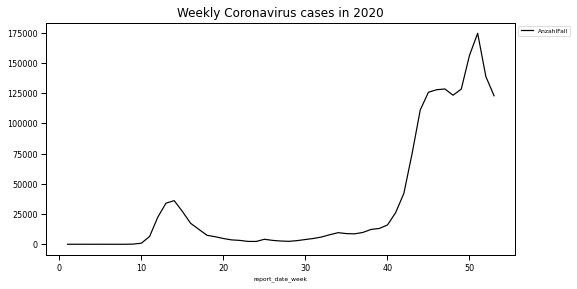

In [20]:
fig, ax = pfunc.plot_line(weekly_cases,
                          title=f'Weekly Coronavirus cases in 2020',
                          filename='total_weekly_cases')

In [21]:
# delay in reporting (date of infection vs. date of reporting to authorities):
report_delay = overview.loc[(overview['report_delay'] >= -30) & (overview['report_delay'] <= 30)]['report_delay']

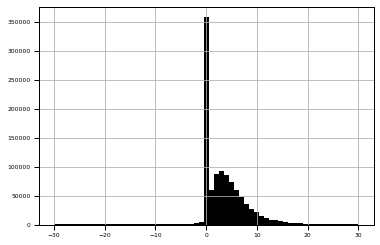

In [22]:
report_delay.hist(bins=61)

The delay between a Coronavirus infection and the notification of authorities is 0 if both occur on the same day OR if the date of infection is unknown. Since the estimated incubation period for the Coronavirus is 3-5 days on average, we can assume that the large number of null values is due to a high number of cases where the infection time (and source) is unknown.

There are many outliers larger that 30 days in the data, as well as negative values, which I assume to be attributed to documentation errors, overload of the responsible authorities etc.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1198FC58>,
      dtype=object)

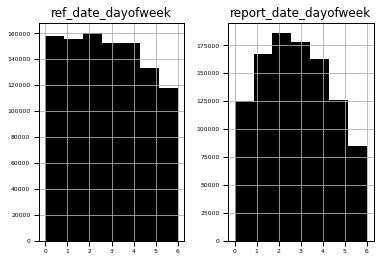

In [23]:
# distribution of report and infection over the week (Mon-Sun)
overview[['report_date_dayofweek', 'ref_date_dayofweek']].hist(bins=7)

In [24]:
tests = tests.set_index(['week'])

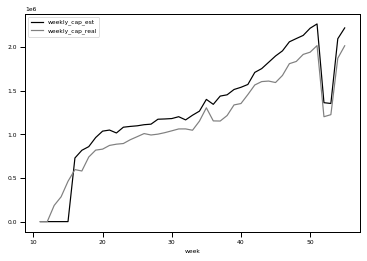

In [25]:
# real and estimated testing capacities
tests[['weekly_cap_est', 'weekly_cap_real']].plot()

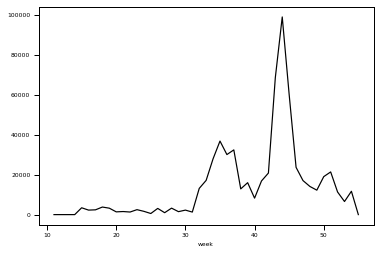

In [26]:
# laboratory tailbacks
tests['tests_tailback'].plot()

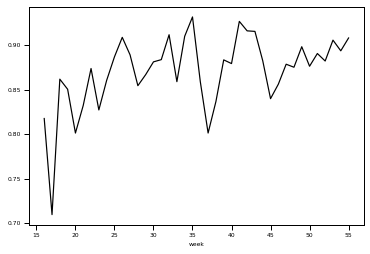

In [27]:
# percentage of real in relation to estimated testing capacities
(tests['weekly_cap_real']/tests['weekly_cap_est']).plot()

Real testing capacities vary between 71% and 94% of estimated testing capacities, but there are no visible overloads which could specifically be attributed to either the pandemic wave in spring or the one in winter. There is a visible low over christmas holidys. Tailbacks in laboratories peaked during the start of the second wave though, with 100000 tests overdue in week 44.

In [28]:
# 

**Definitions**
* case incidence = cases / 100000 people

#### analyse geographical case distribution - how did the pandemic spread across the country?

In [29]:
# total cases per week per federal state in 2020
weekly_cases_per_state = overview.loc[overview['report_date_year'] != 2021].groupby(['Bundesland', 'report_date_week']).sum()['AnzahlFall'].unstack().fillna(0)

In [30]:
# weekly incidence per federal state
weekly_incidence_per_state = (weekly_cases_per_state.div(population_states, axis=0))*100

# total weekly incidence
weekly_incidence = (weekly_cases/total_population)*100

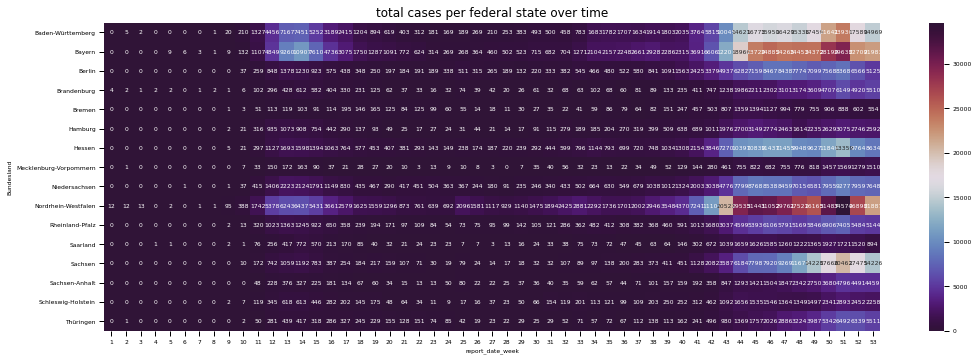

In [31]:
# heatmap: weekly cases per week per federal state in 2020
fig, ax = pfunc.plot_heatmap(weekly_cases_per_state,
                             title='total cases per federal state over time',
                             filename='cases_total_per_state',
                             annot=True, fmt='.0f')

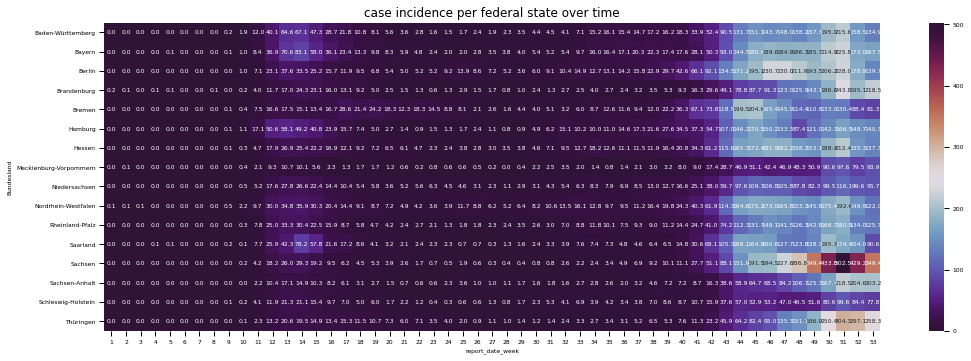

In [32]:
# heatmap: weekly incidence per week per federal state in 2020
fig, ax = pfunc.plot_heatmap(weekly_incidence_per_state,
                             title='case incidence per federal state over time',
                             filename='incidence_state',
                             annot=True, fmt='.1f')

In [33]:
# # heatmap: weekly incidence per week per federal state in 2020 relative to overall incidence
# fig, ax = pfunc.plot_heatmap_and_line(weekly_incidence_per_state,
#                                       x_line=weekly_incidence.index,
#                                       y_line=weekly_incidence, df_line=None,
#                                       title1='case incidence (cases/100.000 people) per federal state over time relative to total case incidence in Germany',
#                                       title2='total case incidence over time',
#                                       filename='incidence_state_relative',
#                                       annot=True, fmt='.1f')

#### analyze case distribution among age groups - who was affected and to what proportions?

In [34]:
# cases per age group over time (total)
age_total = cfunc.remove_column_substr(cases_age1.set_index('Altersgruppe'), '2020_').drop(['Gesamt'], axis=0)

# cases per age group over time (incidence)
age_incidence = cfunc.remove_column_substr(cases_age2.set_index('Altersgruppe'), '2020_')

# cases per age group over time (incidence) relative to overall incidence at the time
# shows the proportion to which an age group was affected in comparison to the overall population
age_norm = age_incidence/age_incidence.iloc[0,:]

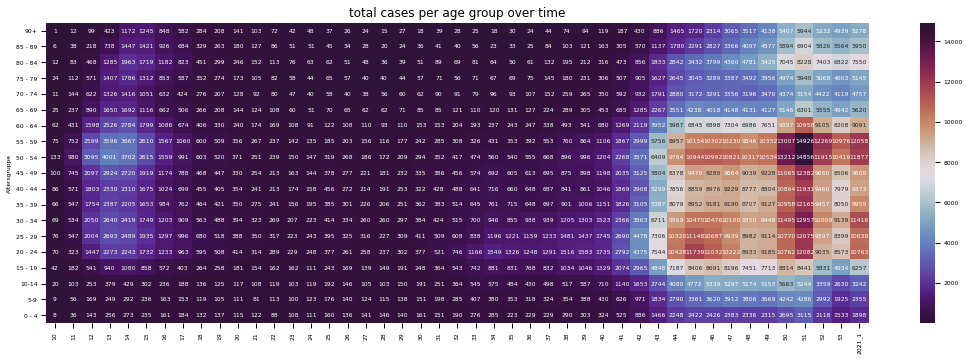

In [35]:
# heatmap: cases per age group over time (total)
fig, ax = pfunc.plot_heatmap(age_total,
                             title='total cases per age group over time',
                             filename='cases_total_per_age',
                             annot=True, fmt='d')

A quick glance at Germany's [age pyramid](https://service.destatis.de/bevoelkerungspyramide/index.html) shows us that age groups with a larger population have higher case numbers. Hence, case incidences (i.e. cases per 100000 people in the respective age group) provide more comparable information about how Coronavirus infections occur across age groups.

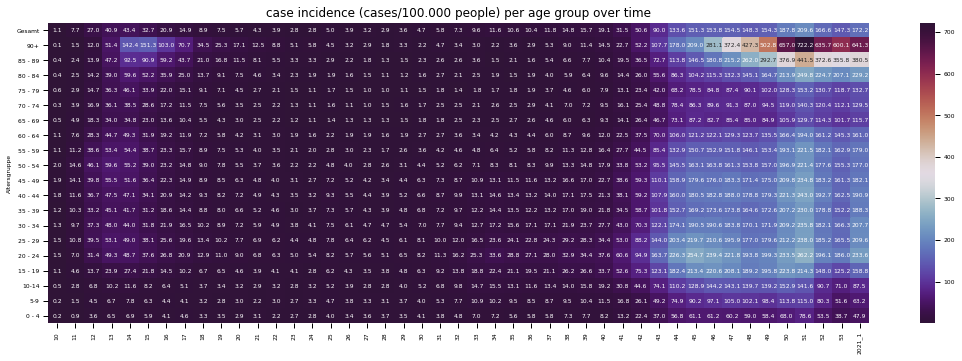

In [36]:
# heatmap: cases per age group over time (incidence)
fig, ax = pfunc.plot_heatmap(age_incidence,
                             title='case incidence (cases/100.000 people) per age group over time',
                             filename='incidence_age_overall',
                             annot=True, fmt='.1f')

The case incidences show that Coronavirus do not occur evenly in all age groups. Those over 85 years of age were actually affected much heavier than all other age groups especially during the second wave, while retirees below 80 and children were affected less. Still, we do not have a clear picture of what happens over the summer.

_Solution: look at the relative case incidence_

The case incidence within a specific group in relation to the general population at the time allows us to visualize better how severely a group was affected in comparison to the general population at the time. Due to the huge range of the overall incidence over time (0-722), smaller variations are otherwise less visible. Bear in mind that the overall incidence is influenced heavily by the larger groups (i.e. the population 30-65 years of age), so these groups tend to be near a relative value of 1.

Another aspect is that when looking at correlations, total numbers and incidences give us strongly positive correlations between nearly all groups. While this holds true (case numbers nearly rise across all age groups during a pandemic), I find it more interesting to see whether two groups being affected over- or underproportionally correlate with each other.

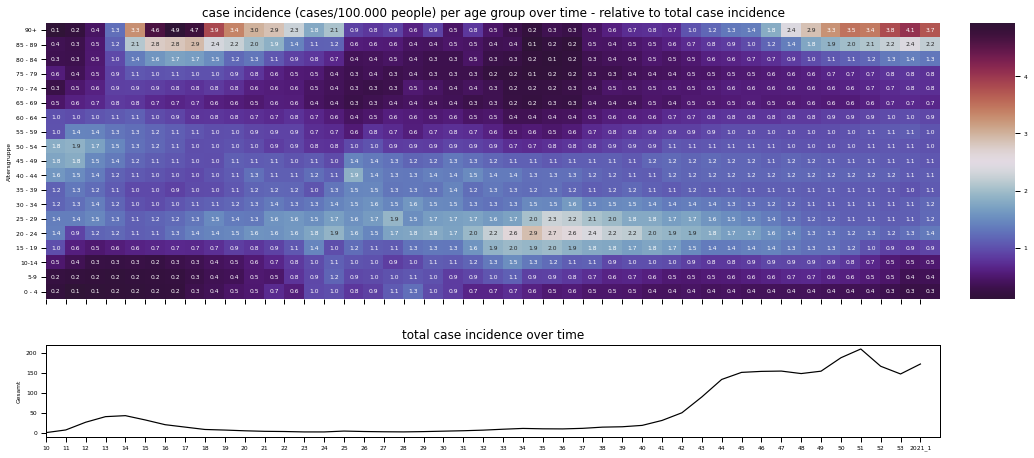

In [37]:
# heatmap: cases per age group over time (incidence) relative to overall case incidence
fig, ax = pfunc.plot_heatmap_and_line(age_norm.drop(['Gesamt'], axis=0),
                                      x_line=age_incidence.iloc[0].index, y_line=age_incidence.iloc[0], df_line=None,
                                      title1='case incidence (cases/100.000 people) per age group over time - relative to total case incidence',
                                      filename='incidence_age_relative',
                                      title2='total case incidence over time',
                                      annot=True, fmt='.1f')

In [38]:
# correlation of relative incidences between age groups
age_groups_corr = age_norm.T.corr()

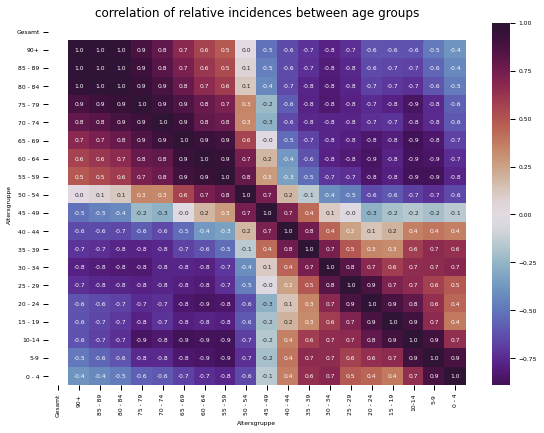

In [39]:
fig, ax = pfunc.plot_heatmap(age_groups_corr,
                             title=f'correlation of relative incidences between age groups',
                             filename='corr_age_groups',
                             annot=True, fmt='.1f', figsize=(8,6), center=0)

#### analyze breakouts - which infection sources are dominant over time and who is affected?
* breakout = 2 or more related cases that were documented as being related
* setting = environment in which the infections occurred

In [40]:
# total number of cases attributed to breakouts - grouped in different infection settings
breakouts_time_per_setting = breakouts.groupby(['week', 'sett_engl'])['num_breakouts'].sum().unstack().fillna(0)

# top 10 infection settings
breakouts_time_per_setting.sum().sort_values(ascending=False).head(n=10)

sett_engl
Private household          101099.0
Retirement/nursing home     86101.0
Unknown                     37317.0
Work place                  20715.0
Hospital                    15849.0
Other                       10260.0
Refugee accomodation         9586.0
Leisure                      7303.0
Residences                   6849.0
Educational institution      5892.0
dtype: float64

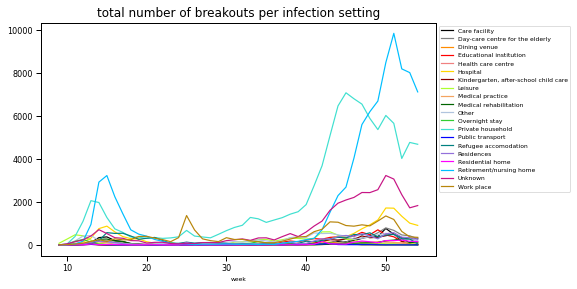

In [41]:
# total number of cases attributed to breakouts per infection setting
fig, ax = pfunc.plot_line(breakouts_time_per_setting,
                          title='total number of breakouts per infection setting',
                          filename='total_breakouts')

In [42]:
# of all documented breakouts, what percentage of cases occurred in which infection setting? 
breakouts_time_per_setting_rel = (breakouts_time_per_setting.div(breakouts_time_per_setting.sum(axis=1), axis=0)).fillna(0)

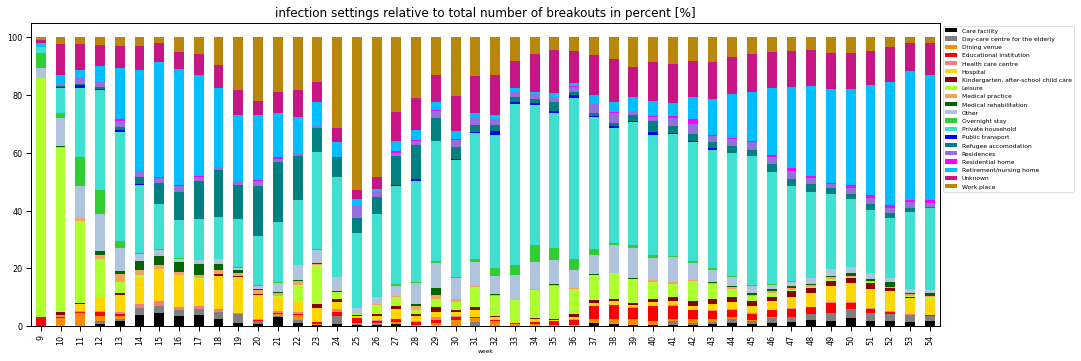

In [43]:
# of all documented breakouts, what percentage of cases occurred in which infection setting?
fig, ax = pfunc.plot_bar(breakouts_time_per_setting_rel*100,
                         title='infection settings relative to total number of breakouts in percent [%]',
                         filename='shares_breakouts',
                         stacked=True)

The number of "unknown" infection sources seems pretty low and stable, given the fact that there were two pandemic waves with rapidly increasing numbers of Coronavirus infections. As a) infection sources are only documented for breakouts, and b) as only 2 or more related cases are documented as a breakout, we have to assume that the infection source of all remaining cases is unknown:

`single_unknown_cases = total_cases - sum(cases_from_breakouts)`

In [44]:
# calculate weekly cases with unknown infection setting as: single_unknown_cases = total_cases - sum(cases_from_breakouts)
unknown_cases = pd.concat([weekly_cases, breakouts_time_per_setting.sum(axis=1).rename('weekly_sum_breakouts')], axis=1).fillna(0).loc[:53, :]
unknown_cases['weekly_single_unknown_cases'] = unknown_cases['AnzahlFall'] - unknown_cases['weekly_sum_breakouts']
unknown_cases['weekly_sum_breakouts_perc'] = unknown_cases['weekly_sum_breakouts']/unknown_cases['AnzahlFall']

mean_reported = unknown_cases['weekly_sum_breakouts_perc'].loc[9:].mean()
print(f'mean percentage of cases that are attributed to a breakout (starting week 9): {round(mean_reported*100, 2)}%')

mean percentage of cases that are attributed to a breakout (starting week 9): 29.92%


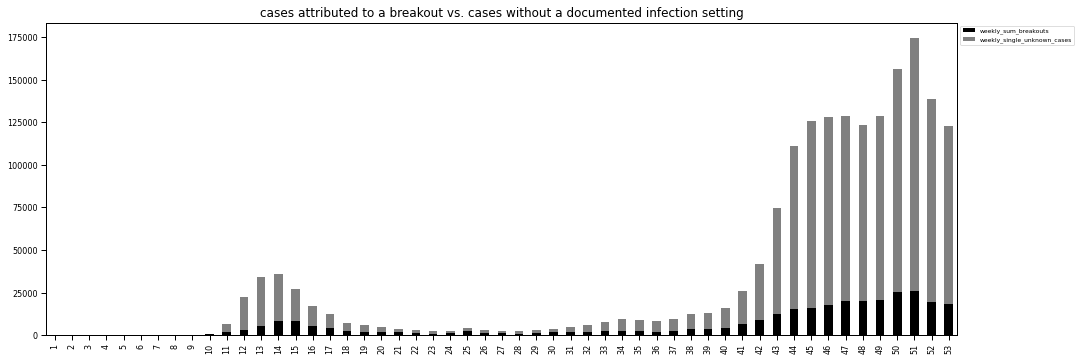

In [45]:
# ccc
fig, ax = pfunc.plot_bar(unknown_cases[['weekly_sum_breakouts', 'weekly_single_unknown_cases']],
                          title=f'cases attributed to a breakout vs. cases without a documented infection setting',
                          filename='unknown_cases', stacked=True)

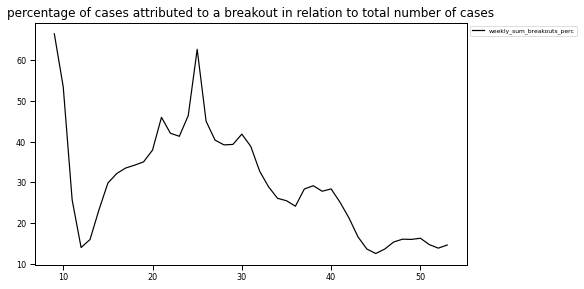

In [46]:
fig, ax = pfunc.plot_line(unknown_cases['weekly_sum_breakouts_perc'].loc[9:]*100,
                          title=f'percentage of cases attributed to a breakout in relation to total number of cases',
                          filename='traced_cases_perc')

In [47]:
# add single unknown cases to breakouts
breakouts_time_per_setting2 = breakouts_time_per_setting.copy(deep=True)
breakouts_time_per_setting2['Unknown single'] = unknown_cases['weekly_single_unknown_cases'].loc[9:]
breakouts_time_per_setting2['Unknown total'] = breakouts_time_per_setting2['Unknown single'] + breakouts_time_per_setting2['Unknown']

# calculate new numbers and percentages of breakouts
breakouts_time_per_setting_rel2 = (breakouts_time_per_setting2.drop(['Unknown single', 'Unknown'], axis=1)
                                   .div(breakouts_time_per_setting2.drop(['Unknown single', 'Unknown'], axis=1).sum(axis=1), axis=0)).fillna(0)

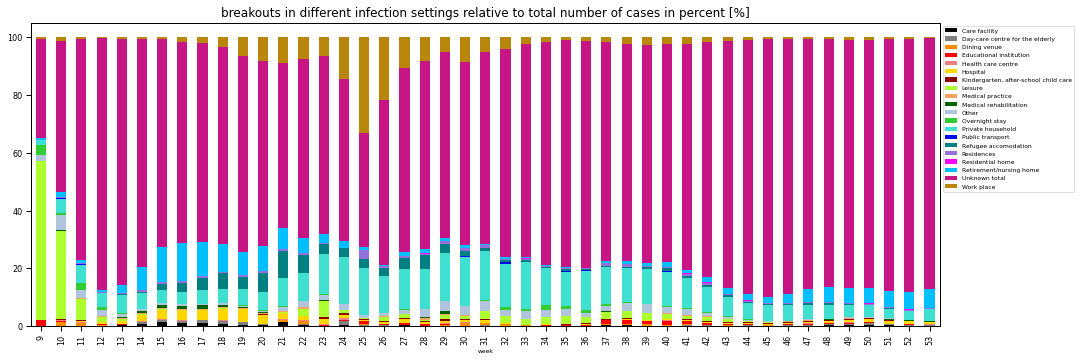

In [48]:
fig, ax = pfunc.plot_bar((breakouts_time_per_setting_rel2.reindex(sorted(breakouts_time_per_setting_rel2.columns), axis=1).loc[:53,:])*100,
                          title=f'breakouts in different infection settings relative to total number of cases in percent [%]',
                          filename='shares_breakouts_total', stacked=True)

explain peaks, distinct patterns in breakouts and age groups

In [49]:
# correlations between relative incidence in age groups and reported breakouts
age_norm_trans = age_norm.rename(columns={'2021_1': '54'}).T
age_norm_trans.index = age_norm_trans.index.astype('int').rename('week')
age_vs_breakouts = pd.concat([breakouts_time_per_setting2, age_norm_trans], axis=1)
age_vs_breakouts_summer = pd.concat([breakouts_time_per_setting2, age_norm_trans], axis=1).loc[18:44, :]

# correlation age vs breakouts: take upper right side of correlation matrix
age_vs_breakouts_corr = age_vs_breakouts.corr().loc[:'Work place', '90+':]

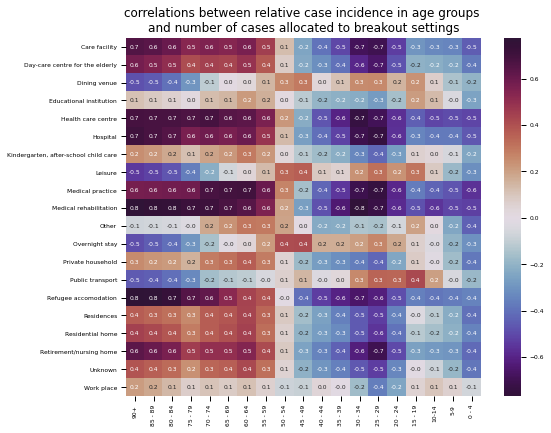

In [50]:
fig, ax = pfunc.plot_heatmap(age_vs_breakouts_corr,
                             title=f'correlations between relative case incidence in age groups \nand number of cases allocated to breakout settings',
                             filename='corr_age_breakouts',
                             annot=True, fmt='.1f', figsize=(8,6), center=0)

#### clinical data

In [51]:
# clinical data: cases, symptoms, hospitalisation
clinical[['no_symptoms_perc', 'hospital_perc', 'deaths_perc']] = clinical[['no_symptoms_perc', 'hospital_perc', 'deaths_perc']]*100

# rates of clinical status reporting for all known cases
clinical['symptom_status_known'] = clinical['symptoms_reported']/clinical['cases_tot']
clinical['hospital_status_known'] = clinical['hospital_reported']/clinical['cases_tot']

# number of known asymptotic cases
clinical['no_symptoms_num'] = clinical['symptoms_reported']*clinical['no_symptoms_perc']/100

clinical['death_vs_tot'] = clinical['deaths_num']/clinical['cases_tot']
clinical['hospital_vs_tot'] = clinical['hospital_num']/clinical['cases_tot']
clinical['asymptomatic_vs_tot'] = clinical['no_symptoms_num']/clinical['cases_tot']

In [52]:
# cumulative percentages of hospitalized cases and deaths per total number of cases
hospitalized_cum = clinical['hospital_num'].sum()/clinical['cases_tot'].sum()
deaths_cum = clinical['deaths_num'].sum()/clinical['cases_tot'].sum()
clinical_corrs = clinical[['cases_tot', 'hospital_num', 'deaths_num']].corr()

print(f'cumulative hospitalizations per total number of infections: {round(hospitalized_cum*100, 2)}%\
        \ncumulative deaths per total number of infections: {round(deaths_cum*100, 2)}%')

cumulative hospitalizations per total number of infections: 6.65%        
cumulative deaths per total number of infections: 2.16%


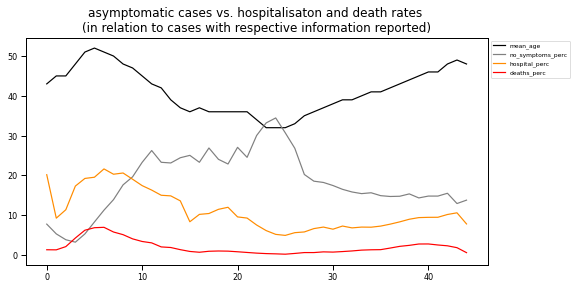

In [53]:
# percentages of hospitalized cases and deaths per cases for whiche the respective information was provided
fig, ax = pfunc.plot_line(clinical[['mean_age', 'no_symptoms_perc', 'hospital_perc', 'deaths_perc']],
                          title=f'asymptomatic cases vs. hospitalisaton and death rates \n(in relation to cases with respective information reported)',
                          filename='clinical_rates_reported')

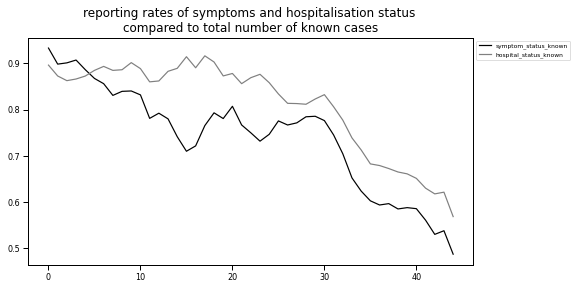

In [54]:
fig, ax = pfunc.plot_line(clinical[['symptom_status_known', 'hospital_status_known']],
                          title=f'reporting rates of symptoms and hospitalisation status \ncompared to total number of known cases',
                          filename='reporting_rates')

#### general information

#### calculate dark figures
implementing a statistical approach based on a study on the influence of social contacts on the spread of infectious diseases. The approach was introduced by Dr. Sascha Feth from the Fraunhofer Institute for Industrial Mathematics ITWM in his [blog](https://www.itwm.fraunhofer.de/de/abteilungen/mf/aktuelles/blog-streuspanne/corona-dunkelziffer.html) and applied to cases in Italy in April 2020.

In [55]:
# replace all incidences with the highest one ath the time:
# worst case for the assumption that infections affect all age groups the same
age_incidence_max = age_incidence.copy(deep=True)

for col in age_incidence.columns:
    age_incidence_max[col] = age_incidence[col].max()
    
age_incidence_max = age_incidence_max.iloc[1:,:]

In [56]:
# multiply by relative number of social contacts (including 95% intervals)
age_incidence_factorized = age_incidence_max.mul(social_factors['social_contacts'], axis=0)
age_incidence_factorized_95_low = age_incidence_max.mul(social_factors['social_contacts_95_low'], axis=0)
age_incidence_factorized_95_high = age_incidence_max.mul(social_factors['social_contacts_95_high'], axis=0)

In [76]:
# get estimated total numbers
age_cases_factorized = ((age_incidence_factorized.mul(population_age, axis=0))/100).loc[:, :'53']
age_cases_factorized_95_low = ((age_incidence_factorized_95_low.mul(population_age, axis=0))/100).loc[:, :'53']
age_cases_factorized_95_high = ((age_incidence_factorized_95_high.mul(population_age, axis=0))/100).loc[:, :'53']

In [86]:
dark_figs = pd.DataFrame()
dark_figs['cases_est'] = age_cases_factorized.sum()
dark_figs['cases_95_low'] = age_cases_factorized_95_low.sum()
dark_figs['cases_95_high'] = age_cases_factorized_95_high.sum()
dark_figs.index = dark_figs.index.astype('int')

dark_figs = pd.concat([dark_figs, weekly_cases], axis=1)

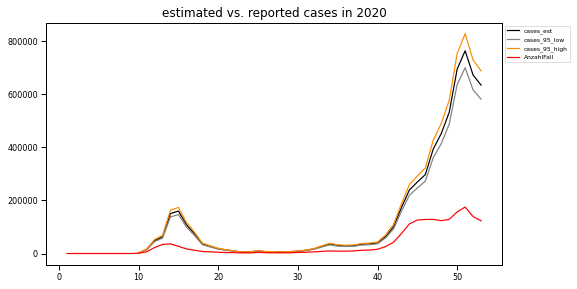

In [87]:
fig, ax = pfunc.plot_line(dark_figs,
                          title=f'estimated vs. reported cases in 2020',
                          filename='estimated_dark_figures')

In [91]:
dark_figs

,cases_est,cases_95_low,cases_95_high,AnzahlFall
1,NaN,NaN,NaN,16
2,NaN,NaN,NaN,21
3,NaN,NaN,NaN,16
4,NaN,NaN,NaN,3
5,NaN,NaN,NaN,14
6,NaN,NaN,NaN,7
7,NaN,NaN,NaN,5
8,NaN,NaN,NaN,5
9,NaN,NaN,NaN,140
10,2088.744768,1914.500610,2264.529168,895


In [90]:
dark_figs['AnzahlFall']/dark_figs['cases_est']).plot()

1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10    0.428487
11    0.417742
12    0.461082
13    0.540943
14    0.240306
15    0.170337
16    0.159805
17    0.165993
18    0.204530
19    0.233890
20    0.263132
21    0.274152
22    0.347974
23    0.438654
24    0.381289
25    0.422133
26    0.476191
27    0.410367
28    0.447781
29    0.437643
30    0.456934
31    0.404319
32    0.354994
33    0.298244
34    0.270928
35    0.290642
36    0.301814
37    0.330848
38    0.353820
39    0.360796
40    0.400954
41    0.409453
42    0.420216
43    0.433231
44    0.465649
45    0.468201
46    0.431237
47    0.327189
48    0.273691
49    0.242076
50    0.225473
51    0.229173
52    0.206967
53    0.194146
dtype: float64

Check out this [dashboard](https://covid19.dunkelzifferradar.de/) for another approach for estimating undetected Coronavirus infections based on case mortality. The model uses differential equations, wherein the mortality parameter can be configured by the user.

At the peak of the second wave in CW 51, this dashboard yields a maximum number of undetected infections of over 1.6 million cases, which is double the value derived from the calculation above and 8 times the number of reported cases.